# VGG-16

![](../img/vgg16_1.png)


![](../img/vgg16_2.png)

Phân tích:

- Convolutional layer: kích thước 3*3, padding=1, stride=1. Tại sao không ghi stride, padding mà vẫn biết? Vì mặc định sẽ là stride=1 và padding để cho output cùng width và height với input.
- Pool/2 : max pooling layer với size 2*2
- 3*3 conv, 64: thì 64 là số kernel áp dụng trong layer đấy, hay depth của output của layer đấy.
- Càng các convolutional layer sau thì kích thước width, height càng giảm nhưng depth càng tăng.
- Sau khá nhiều convolutional layer và pooling layer thì dữ liệu được flatten và cho vào fully connected layer.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Thực hiện VGG-16 cho bài taons Detect Brain Tumor

In [2]:
import torch
import torchvision
from torch.optim import lr_scheduler
import torch.nn as nn 
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import InterpolationMode
import torchvision.transforms.functional as TF
import numpy as np
import cv2
import os
import time
import copy
import imutils
from PIL import Image
import shutil
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import matplotlib.pyplot as plt
import tensorboard
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/brain_tumor')

## Abstract

A brain tumor is a distorted tissue wherein cells replicate rapidly and indefinitely, with
no control over tumor growth. Deep learning has been argued to have the potential to overcome
the challenges associated with detecting and intervening in brain tumors. It is well established
that the segmentation method can be used to remove abnormal tumor regions from the brain, as
this is one of the advanced technological classification and detection tools. In the case of brain
tumors, early disease detection can be achieved effectively using reliable advanced A.I. and Neural
Network classification algorithms. This study aimed to critically analyze the proposed literature
solutions, use the Visual Geometry Group (VGG 16) for discovering brain tumors, implement a
convolutional neural network (CNN) model framework, and set parameters to train the model for
this challenge. VGG is used as one of the highest-performing CNN models because of its simplicity.
Furthermore, the study developed an effective approach to detect brain tumors using MRI to aid
in making quick, efficient, and precise decisions. Faster CNN used the VGG 16 architecture as a
primary network to generate convolutional feature maps, then classified these to yield tumor region
suggestions. The prediction accuracy was used to assess performance. Our suggested methodology
was evaluated on a dataset for brain tumor diagnosis using MR images comprising 253 MRI brain
images, with 155 showing tumors. Our approach could identify brain tumors in MR images. In the
testing data, the algorithm outperformed the current conventional approaches for detecting brain
tumors (Precision = 96%, 98.15%, 98.41% and F1-score = 91.78%, 92.6% and 91.29% respectively) and
achieved an excellent accuracy of CNN 96%, VGG 16 98.5% and Ensemble Model 98.14%. The study
also presents future recommendations regarding the proposed research work.

## VGG-16

![](../img/vgg_16.png)

## Setup device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data import and Preprocessing

In [ ]:
# listFolder = ["TRAIN/YES", "TRAIN/NO", "TEST/YES", "TEST/NO", "VAL/YES", "VAL/NO"]
# for folder in listFolder:
#     DIR = f"./drive/MyDrive/ml_isofh/data/brain_tumor_dataset/{folder}"
#     if not os.path.exists(DIR):
#         os.mkdir(DIR)
        
# # clean old data
# for folder in listFolder:
#     DIR = f"./drive/MyDrive/ml_isofh/data/brain_tumor_dataset/{folder}"
#     for file in os.listdir(DIR):
#         os.remove(f"{DIR}/{file}")

# print("NEW files created!")


# # Preparing folder data and train, test, val set
# IMG_PATH = './drive/MyDrive/ml_isofh/data/brain_tumor_dataset/'

# for CLASS in os.listdir(IMG_PATH):
#     if not CLASS.startswith(".") and CLASS !='TEST' and CLASS !='TRAIN' and CLASS !='VAL':
#         IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
#         for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
#             img = IMG_PATH + CLASS + '/' + FILE_NAME
#             # split data 30 % for test
#             if n< 0.2*IMG_NUM:
#                 shutil.copy(img, IMG_PATH +"TEST/" + CLASS.upper() + '/' + FILE_NAME)
#             # split data 60% for training
#             elif n< IMG_NUM*0.92:
#                 shutil.copy(img, IMG_PATH +"TRAIN/"+ CLASS.upper() + '/' + FILE_NAME)
#             # the rest is for validation
#             else:
#                 shutil.copy(img, IMG_PATH +"VAL/" + CLASS.upper() + '/' + FILE_NAME)

# print("Successfully migrated data")

NEW files created!
Successfully migrated data


## Hyper parameters

In [4]:
num_epochs = 100
batch_size = 4
learning_rate = 1e-4

## Load data

In [5]:
TRAIN_DIR = './drive/MyDrive/ml_isofh/data/brain_tumor_dataset/TRAIN'
TEST_DIR = './drive/MyDrive/ml_isofh/data/brain_tumor_dataset/TEST'
VAL_DIR = './drive/MyDrive/ml_isofh/data/brain_tumor_dataset/VAL'
IMG_SIZE = (224, 224)

# Take Mean and std
samples_set = datasets.ImageFolder(TRAIN_DIR, transform=transforms.Resize((224, 224)))

def readToNumpy(imagesSet):
    listImgs = []
    for img_path in imagesSet:
        img = cv2.imread(img_path[0])
        listImgs.append(cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA))
    return np.array(listImgs)

listImgs = readToNumpy(samples_set.imgs)

MEAN = (listImgs/255.0).mean((0,1,2))
STD = (listImgs /255.0).std((0,1,2))

MEAN, STD

(array([0.23685642, 0.23674977, 0.23642515]),
 array([0.22949252, 0.22923947, 0.22891869]))

In [7]:
# This line of code is to auto completion of code using key "Tab". Just make coding faster ^^! 
# I read from this post "https://www.kaggle.com/getting-started/51622"
%config Completer.use_jedi = False

## Custom Dataset

In [8]:
class BrainTumor(Dataset):
    def __init__(self, root, transforms=None):
        imageData = datasets.ImageFolder(root)
        self.n_samples = len(imageData.imgs)  
        self.data = np.array([cv2.imread(img_path[0]) for img_path in imageData.imgs])
        self.targets = np.array(imageData.targets)
        self.classes = imageData.classes
        self.transforms = transforms
    def __len__(self):
        return self.n_samples
    def __getitem__(self, index):
        x = self.data[index]
        # print(self.data[index].shape, self.targets[index].shape)
        if self.transforms:
            x = self.transforms(x)
            # change = self.transforms(self.data[index])
            # sample = change, self.targets[index]
        return x,  self.targets[index]

In [9]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

## Preprocessing data

In [10]:

class ImageEnhanced(object):
    """_summary_
    transform to enhanced image quality for prediction 
    """
    def __init__(self):
        pass
    def __call__(self, img ,add_pixels_value = 0):
        
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)
        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)
        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])
        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        return Image.fromarray(new_img)
            
# class Flip(object):
#     def __init__(self)    
# Data trasform

# Crop only
transformsImg = transforms.Compose([
    ImageEnhanced(),
    transforms.ToTensor(),
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop((224,224),scale=(0.8,1.0),ratio=(0.9,1.1)),
    transforms.Normalize(MEAN, STD)
])

test_transform = transforms.Compose([
    ImageEnhanced(),
    transforms.ToTensor(),
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.Normalize(MEAN, STD)
])
train_transform = transforms.Compose([
    ImageEnhanced(),
    transforms.ToTensor(),
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.ColorJitter(brightness=[0.1, 1.5]),
    # transforms.RandomAffine(degrees=40, translate=None, shear=0.1, resample=False, fillcolor=0),
    # transforms.ColorJitter(brightness=[0.1, 1.5]),
    # transforms.RandomAffine(),
    transforms.RandomResizedCrop((224,224),scale=(0.8,1.0),ratio=(0.9,1.1)),
    transforms.Normalize(MEAN, STD)
])

# load data
train_dataset = BrainTumor(root=TRAIN_DIR, transforms=train_transform)
test_dataset = BrainTumor(TEST_DIR, transforms=test_transform)
val_dataset = BrainTumor(VAL_DIR, transforms=test_transform)

# data shape
print(f"train set :{train_dataset.data.shape}")
print(f"test set: {test_dataset.data.shape}")
print(f"val set: {val_dataset.data.shape}")
# # data loader
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size, drop_last=False)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size, drop_last=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


train set :(183,)
test set: (51,)
val set: (19,)


## Image visualization

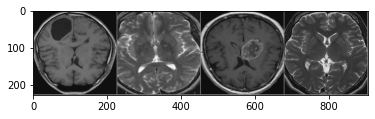

No           No           Yes          No          


In [11]:
classes = ('No', 'Yes')
NUM_IMGS = batch_size

show_samples = iter(train_loader)
images,labels = show_samples.next()

imgs = torchvision.utils.make_grid(images, normalize=True, pad_value=0.5)

# Convert images to a readable numpy for plt
imgs = imgs.numpy()

# Transform imgs to an array of images
imgs = imgs.transpose((1,2,0))

# Show images
plt.imshow(imgs)
plt.show()

print(' '.join(f'{classes[labels[j]]:12s}' for j in range(NUM_IMGS)))

## Pre-trained model

In [23]:

# Custom

class VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            self.Conv(3, 64),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            self.Conv(64, 64),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2))
        )
        self.layer3 = nn.Sequential(
            self.Conv(64, 128),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            self.Conv(128, 128),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
        self.layer5 = nn.Sequential(
            self.Conv(128, 256),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            self.Conv(256, 256),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            self.Conv(256, 256),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            self.Conv(256, 512),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            self.Conv(512, 512),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            self.Conv(512, 512),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            self.Conv(512, 512),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            self.Conv(512, 512),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            self.Conv(512, 512),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7,7))
        self.fc = nn.Sequential(
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 1000),
            nn.Sigmoid())
    def Conv(self, in_size, out_size):
        return nn.Conv2d(in_size, out_size, kernel_size=(3, 3), stride=1, padding=1)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = self.avgpool(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)

# Using availabel VGG16
model_ft = torchvision.models.vgg16(pretrained=True).to(device)
model_ft.classifier[6].out_features = 2
# Add more layer to new model
print(type(model_ft.classifier))
# model_ft.classifier.append(nn.Sequential(
#     nn.Dropout(0.5),
#     nn.Linear(1000, 2),
#     nn.Sigmoid()
# ))
# model_ft.to(device)

# freeze convolution weights
for param in model_ft.features.parameters():
    param.requires_grad = False
    


print(model_ft.classifier)


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(model_ft.classifier.parameters(), lr=learning_rate,weight_decay=1e-2, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, 
                                           milestones=[100, 150], 
                                           gamma=0.1)



/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<class 'torch.nn.modules.container.Sequential'>
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)


## Training

In [18]:
dataloaders = {'TRAIN':train_loader, 'VAL':val_loader}
dataset_sizes = {'TRAIN':train_dataset.data.shape[0], 'VAL':test_dataset.data.shape[0]}
min_valid_loss = np.inf
# validation function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    n_samples = 0
    for idx, (images, labels) in enumerate(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = criterion(output, labels)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output, 1)
        val_running_correct += (preds == labels).sum().item()
        n_samples += labels.size(0)

    # if min_valid_loss > val_loss:
    #   print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{val_loss:.6f}) \t Saving The Model')
    #   min_valid_loss = val_loss
    #   torch.save(model.state_dict(), 'saved_model.pth')
    val_loss = val_running_loss/n_samples
    val_accuracy = 100. * val_running_correct/n_samples
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')

    return val_loss, val_accuracy

# training function
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    n_samples = 0
    for i, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        train_running_loss += loss.item()
        _, preds = torch.max(output, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
        n_samples += labels.size(0)
    train_loss = train_running_loss/n_samples
    train_accuracy = 100. * train_running_correct/n_samples
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

In [19]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1} / {num_epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(model_ft, train_loader)
    val_epoch_loss, val_epoch_accuracy = validate(model_ft, test_loader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    print("-"*10)
end = time.time()
print((end-start)/60, 'minutes')

Epoch 1 / 100
Train Loss: 1.1939, Train Acc: 32.22
Val Loss: 0.1766, Val Acc: 66.67
----------
Epoch 2 / 100
Train Loss: 0.1601, Train Acc: 74.44
Val Loss: 0.1621, Val Acc: 74.51
----------
Epoch 3 / 100
Train Loss: 0.1314, Train Acc: 73.33
Val Loss: 0.1170, Val Acc: 76.47
----------
Epoch 4 / 100
Train Loss: 0.1363, Train Acc: 77.22
Val Loss: 0.1164, Val Acc: 74.51
----------
Epoch 5 / 100
Train Loss: 0.1304, Train Acc: 80.00
Val Loss: 0.1051, Val Acc: 86.27
----------
Epoch 6 / 100
Train Loss: 0.1243, Train Acc: 75.56
Val Loss: 0.1072, Val Acc: 76.47
----------
Epoch 7 / 100
Train Loss: 0.1209, Train Acc: 76.11
Val Loss: 0.0911, Val Acc: 88.24
----------
Epoch 8 / 100
Train Loss: 0.1123, Train Acc: 80.00
Val Loss: 0.0876, Val Acc: 86.27
----------
Epoch 9 / 100
Train Loss: 0.0912, Train Acc: 85.00
Val Loss: 0.0892, Val Acc: 84.31
----------
Epoch 10 / 100
Train Loss: 0.0827, Train Acc: 86.67
Val Loss: 0.0872, Val Acc: 86.27
----------
Epoch 11 / 100
Train Loss: 0.0808, Train Acc: 87.

In [20]:
# model_ft.load_state_dict(torch.load('./saved_model.pth'))
model_ft.eval()
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for (images, labels) in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model_ft(images)
    _, pred = torch.max(outputs, 1)

    n_correct += (pred == labels).sum().item()
    n_samples += labels.size(0)

  print(f"Accuracy {n_correct / n_samples * 100} %")



Accuracy 90.19607843137256 %


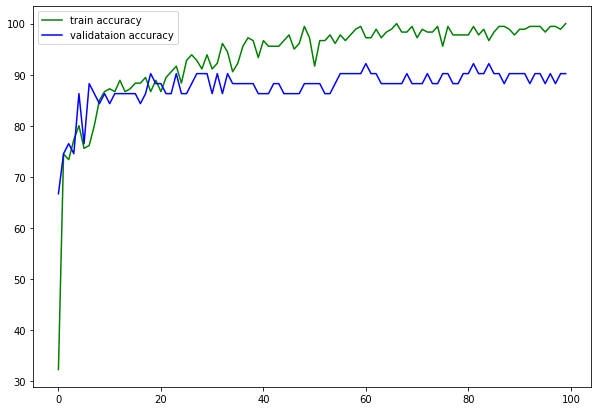

In [21]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

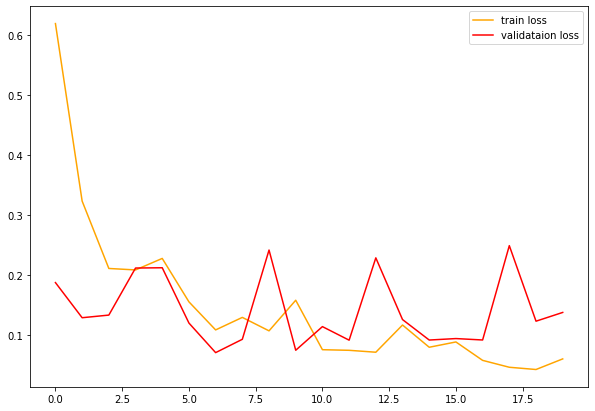

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()